In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import nltk
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

#Importing Classifier Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Importing Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
cols = ['id', 'field', 'target', 'text']

df1 = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", names=cols)
df2 = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", names=cols)

In [18]:
df1.head()

,id,field,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [19]:
df2.head()

,id,field,target,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [20]:
df = pd.concat([df1, df2], ignore_index=False)

df.head()

,id,field,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [22]:
print("Dataset has {} rows and {} columns.".format(df.shape[1], df.shape[0]))

Dataset has 4 rows and 75682 columns.


In [26]:
print("Dataset has \n {} \n missing values.".format(df.isnull().sum()))

print("Dataset has {} duplicated values.".format(df.duplicated().sum()))

Dataset has 
 id          0
field       0
target      0
text      686
dtype: int64 
 missing values.

Dataset has 3217 duplicated values.


In [27]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [28]:
df.head()

,id,field,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


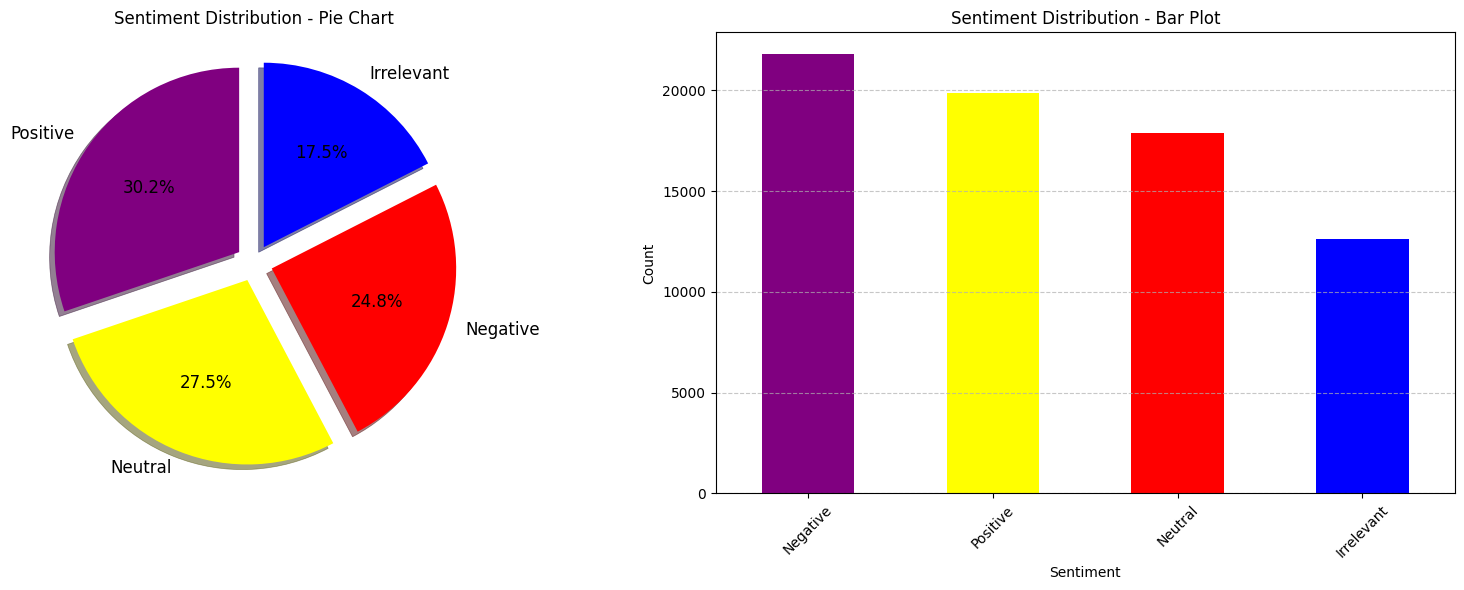

In [30]:
#Define colors
colors = ['purple', 'yellow', 'red', 'blue']

#Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

#Plotting pie chart for sentiment distribution
axs[0].pie(df['target'].value_counts(), labels=df['target'].unique(), autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 12},
            explode=[0.1, 0.1, 0.1, 0.1], colors=colors, shadow=True)
axs[0].set_title('Sentiment Distribution - Pie Chart')

# Plotting bar plot for sentiment distribution
axs[1] = df['target'].value_counts().plot(kind='bar', color=colors, ax=axs[1])
axs[1].set_title('Sentiment Distribution - Bar Plot')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

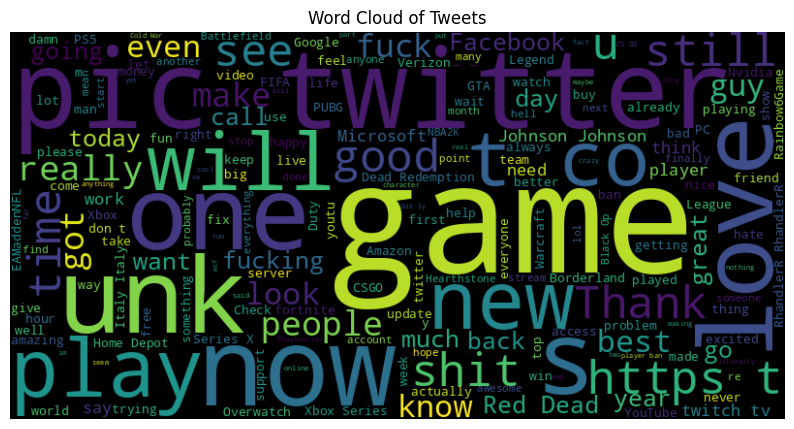

In [32]:
#Concatenate all tweets into a single string
all_tweets_text = ' '.join(df['text'])

#Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_tweets_text)

# Plot word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

In [34]:
decode_map = {'Negative': 0, 'Neutral': 1, 'Irrelevant': 1, 'Positive': 2}

def decode_sentiment(label): #Decoding labels.
    
    return decode_map[label]

df2['target'] = df2['target'].apply(lambda x: decode_sentiment(x))

def filter_string(df, column):    #Filter out rows with non-string values in the specified column.

    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

def normalize_text(text): #Convert text to lowercase to ensure consistency across the corpus.

    return text.lower()

def remove_html(text):  #Remove HTML tags from the texts. (such as <br>, <p>).
    
    return re.sub(r'<.*?>', '', text)

def remove_urls(text): #Remove URLs or hyperlinks from the text.

    return re.sub(r'http\S+|www\S+', '', text)

def remove_numbers(text): #Remove numerical digits from the text.

    return re.sub(r'\d+', '', text)

def remove_punctuation(text):  #Remove punctuation marks from the text.
    
    return text.translate(str.maketrans('', '', string.punctuation))

def tokenize_text(text): #Split the text into individual words or tokens.

    return word_tokenize(text)

def remove_stopwords(tokens): #Eliminate common stopwords from the tokenized text.

    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def remove_emojis(text): #Remove emojis from the text.
    
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F" 
                                   u"\U0001F300-\U0001F5FF"  
                                   u"\U0001F680-\U0001F6FF"  
                                   u"\U0001F1E0-\U0001F1FF"  
                                   u"\U00002500-\U00002BEF"  
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text
    


In [36]:
df['target'] = df['target'].apply(lambda x: decode_sentiment(x)) #Applying decoding function.

In [37]:
def preprocess_text(df):
    df = filter_string(df, 'text')
    df['text'] = df['text'].apply(normalize_text)
    df['text'] = df['text'].apply(remove_html)
    df['text'] = df['text'].apply(remove_urls)
    df['text'] = df['text'].apply(remove_numbers)
    df['text'] = df['text'].apply(remove_punctuation)
    df['text'] = df['text'].apply(tokenize_text)
    df['text'] = df['text'].apply(remove_stopwords)
    df['text'] = df['text'].apply(remove_emojis)
    return df

In [38]:
df_processed = preprocess_text(df)

In [39]:
df_processed.drop(columns=['id', 'field'], inplace=True) #Dropping unnecessary columns from dataset.

df_processed

,target,text
0,2,"[im, getting, borderlands, murder]"
1,2,"[coming, borders, kill]"
2,2,"[im, getting, borderlands, kill]"
3,2,"[im, coming, borderlands, murder]"
4,2,"[im, getting, borderlands, murder]"
...,...,...
988,1,"[♥️, suikoden, ️⃣, alex, kidd, miracle, world,..."
989,2,"[thank, matching, funds, home, depot, rw, paym..."
991,1,"[late, night, stream, boys, come, watch, warzo..."
995,1,"[⭐️, toronto, arts, culture, capital, canada, ..."


In [40]:
#df_processed contains preprocessed text data.
#Convert list of words into a single string for each entry in 'text' column.
df_processed['text'] = df_processed['text'].apply(lambda x: ' '.join(x))

#Split data into features (X) and target (y).
X = df_processed['text']  #Features
y = df_processed['target']  #Target

#Split data into training and testing sets (80% training, 20% testing).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Print the shapes of the training and testing sets.
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (57711,)
Shape of X_test: (14428,)
Shape of y_train: (57711,)
Shape of y_test: (14428,)


In [41]:
#Convert text data to TF-IDF features.
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [42]:
#Logistic Regression Model.

log_clf = LogisticRegression(random_state=42, max_iter=3000)

Test Accuracy: 0.8093290823398946


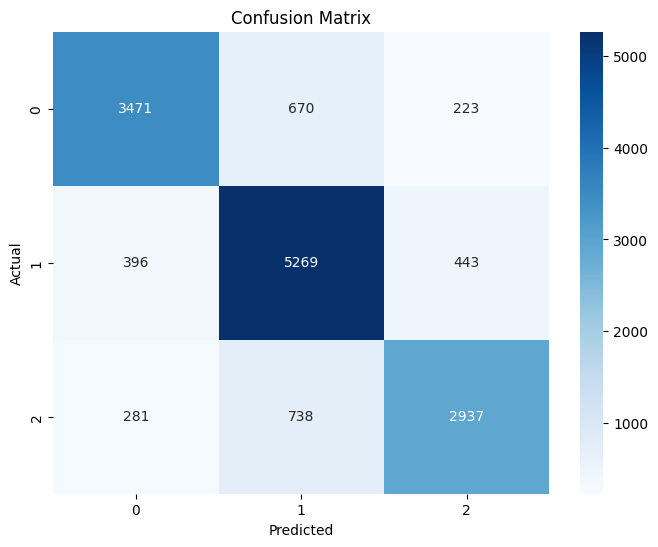

In [46]:
#Training and Testing Logistic Regression Model.

log_clf.fit(X_train_tfidf, y_train)

#Predict on the testing data.
y_pred_log = log_clf.predict(X_test_tfidf)

#Calculate accuracy.
accuracy = accuracy_score(y_test, y_pred_log)
print("Test Accuracy:", accuracy)

#Plotting Confusion Matrix.
conf_matrix_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
#Random Forest Classifier Model.

rf_clf = RandomForestClassifier(random_state=42)

Test Accuracy: 0.9156501247574161


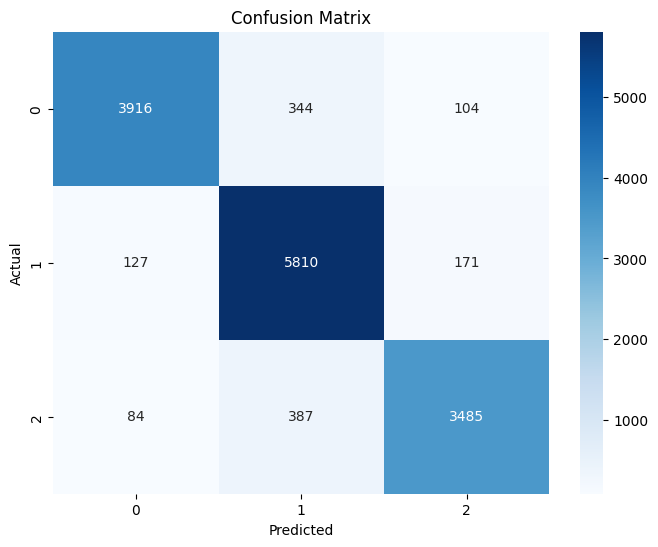

In [48]:
#Training and RandomForestClassifier model.

rf_clf.fit(X_train_tfidf, y_train)

#Testing model.
y_pred_randomf = rf_clf.predict(X_test_tfidf)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_randomf)
print("Test Accuracy:", accuracy_rf)

#Plotting Confusion Matrix.
conf_matrix_rf = confusion_matrix(y_test, y_pred_randomf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()